In [1]:
from util.visualise import *

/home/dillon/anaconda3/envs/torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PAPER_DIR = str(Path.home())+"/papers/24-aaai-goose/paper"

PLOT_DIR = f"{PAPER_DIR}/plots"
PLOT_DIR

'/home/dillon/papers/24-aaai-goose/paper/plots'

In [3]:
L=4
aggr="max"
H=64

CONFIGS = ["hff", "ddg-el dd", "ddg-el di", "sdg-el dd", "fdg-el dd", "ldg-el dd", "sdg-el di", "fdg-el di", "ldg-el di"]

In [4]:
h_opt = {}
for domain in GOOSE_DOMAINS:
    problem_pddls = sorted_nicely(os.listdir(f"../benchmarks/goose/{domain}/test"))
    for problem_pddl in problem_pddls:
        problem_name = os.path.basename(problem_pddl).replace(".pddl", "")

        key = (domain, problem_name)
        f = f'logs/seq-opt-mns/{domain}_{problem_name}_seq-opt-mns.log'
        for line in open(f, 'r').readlines():
            if 'Plan cost: ' in line:
                h_opt[key] = int(line.split()[-1])
        
        if key in h_opt:
            continue

        # hardcode opt for some problems
        if domain == "gripper":
            n = int(problem_name.replace("gripper-n", ""))
            h_opt[key] = n * 3 - (n % 2 == 0)
        elif domain == "visitall":
            for i in range(5):
                problem_name = problem_name.replace(f"-s{i}", '')
            n = int(problem_name.replace("n", ""))
            h_opt[key] = n * n - 1
        elif domain == "spanner":
            nums = [int(s) for s in re.findall(r'\d+', problem_name)]
            s = nums[0]
            n = nums[1]
            l = nums[2]
            h_opt[key] = 2*n + l + 1
        elif domain == "ferry":
            nums = [int(s) for s in re.findall(r'\d+', problem_name)]
            n_locs = nums[0]
            n_cars = nums[1]
            ferry = -1

            locs = {l:set() for l in range(n_locs)}  # only stores non goal cars
            cars = {}
            goal = {}

            goal_time = False
            for line in open(f"../benchmarks/goose/{domain}/test/{problem_pddl}", 'r').readlines():
                if "(:goal" in line:
                    goal_time = True
                    continue

                if "(at-ferry" in line:
                    line = line.split()
                    ferry = int(line[-1].replace('l', '').replace(')', ''))
                    continue

                if "(at " in line:
                    line = line.split()
                    car = int(line[1].replace('c', ''))
                    loc = int(line[-1].replace('l', '').replace(')', ''))
                    if not goal_time:
                        locs[loc].add(car)
                        cars[car] = loc
                    else:
                        goal[car] = loc
            
            # solve problem
            opt = 0
            while True:
                # check goal:
                is_goal = True
                for car in range(n_cars):
                    if cars[car] != goal[car]:
                        is_goal = False
                        break
                if is_goal:
                    break
                    
                # greedy find car whose goal location has non goal cars
                car_to_transport = -1
                for car in locs[ferry]:
                    if cars[car] != goal[car] and len(locs[goal[car]]) > 0:
                        car_to_transport = car
                        car_loc = ferry
                        break
                if car_to_transport == -1:
                    # if all car goal locations are empty
                    for car in locs[ferry]:
                        if cars[car] != goal[car]:
                            car_to_transport = car
                            car_loc = ferry
                            break
                
                if car_to_transport != -1:
                    locs[car_loc].remove(car)
                    ferry = goal[car]
                    cars[car_to_transport] = goal[car_to_transport]
                    opt += 3
                else:
                    for car in range(n_cars):
                        if cars[car] != goal[car]:
                            car_to_transport = car
                            car_loc = cars[car]
                            break

                    locs[car_loc].remove(car)
                    ferry = goal[car]
                    cars[car_to_transport] = goal[car_to_transport]
                    opt += 4
            # end while
            h_opt[key] = opt

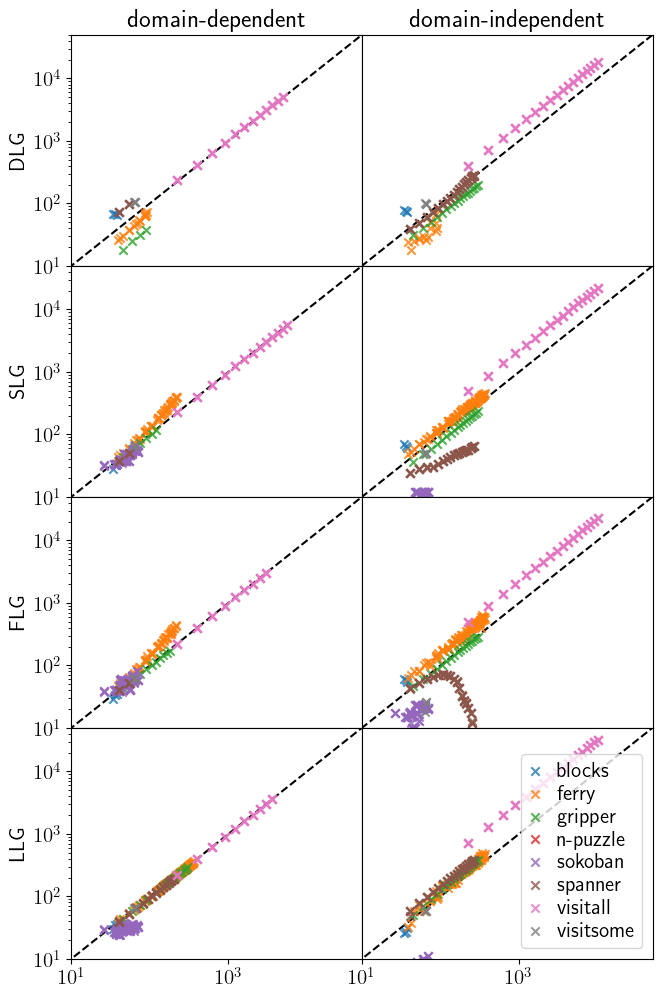

<Figure size 640x480 with 0 Axes>

In [29]:
SIZE = 3
AXES_MIN = 1e1
AXES_MAX = 5e4
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(2.5*SIZE, 4*SIZE))

plt.rcParams.update({
    "text.usetex": True,
    "font.size": 15,
})

for i, rep in enumerate(["ddg-el", "sdg-el", "fdg-el", "ldg-el"]):
  for j, train_type in enumerate(["dd", "di"]):

    # plotting
    for domain in GOOSE_DOMAINS:
        xs = []
        ys = []

        problem_pddls = os.listdir(f"../benchmarks/goose/{domain}/test")
        for problem_pddl in problem_pddls:
            problem_name = os.path.basename(problem_pddl).replace(".pddl", "")

            key = (domain, problem_name)
            if key not in h_opt:
                continue
            
            p = 20 if train_type == "di" else 10
            f = f'logs/test/{problem_name}_{train_type}_{rep}_{domain}_L{L}_H{H}_{aggr}_p{p}_r0.log'
            
            x = h_opt[key]
            y = scrape_search_log(f)["first_h"]

            xs.append(x)
            ys.append(y)

        
        axs[i,j].scatter(xs, ys, label=domain, marker='x', alpha=0.8)
    axs[i,j].plot([1, AXES_MAX], [1, AXES_MAX], linestyle='dashed', color='k', zorder=0)
    axs[i,j].set_xscale('log')
    axs[i,j].set_yscale('log')
    axs[i,j].set_xlim(left=AXES_MIN, right=AXES_MAX)
    axs[i,j].set_ylim(bottom=AXES_MIN, top=AXES_MAX)
    # axs[i,j].set_aspect('equal')

    if i<3:
       axs[i,j].xaxis.set_visible(False)
    if j>0:
       axs[i,j].yaxis.set_visible(False)
    if i==0:
       title = "domain-dependent" if train_type=="dd" else "domain-independent"
       axs[i,j].set_title(title)
    if j==0:
       axs[i,j].set_ylabel(CONFIG_TO_PURE_TEX[rep])


plt.subplots_adjust(hspace=0,wspace=0)
plt.legend(labelspacing=0.2, handlelength=0.5)
# plt.tight_layout()
plt.savefig(f"{PLOT_DIR}/combined-predict-vertical.pdf", bbox_inches='tight')
plt.show()
plt.clf()

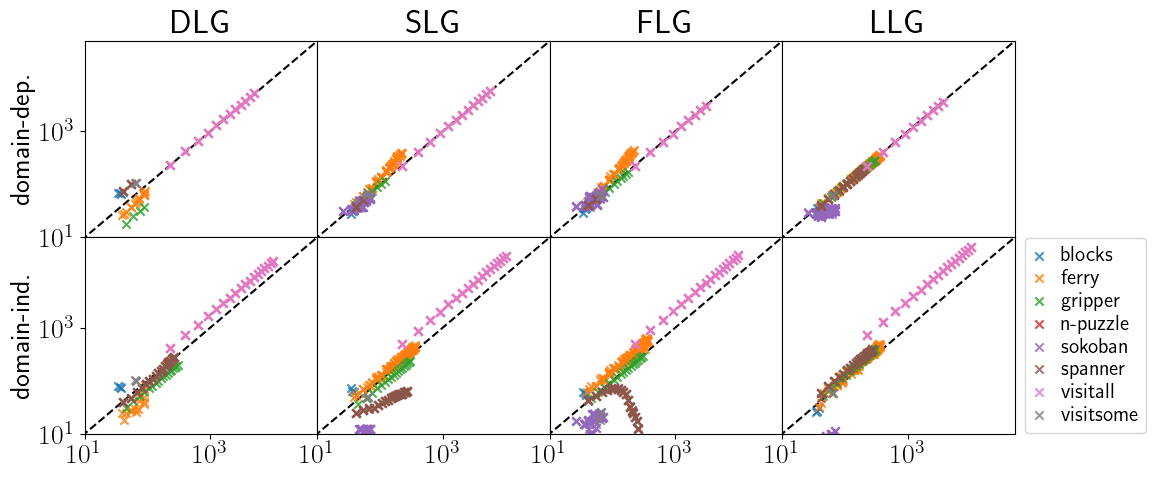

<Figure size 640x480 with 0 Axes>

In [38]:
SIZE = 3
AXES_MIN = 1e1
AXES_MAX = 5e4
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(4*SIZE, 1.7*SIZE))

plt.rcParams.update({
    "text.usetex": True,
    "font.size": 20,
})

for j, rep in enumerate(["ddg-el", "sdg-el", "fdg-el", "ldg-el"]):
  for i, train_type in enumerate(["dd", "di"]):

    # plotting
    for domain in GOOSE_DOMAINS:
        xs = []
        ys = []

        problem_pddls = os.listdir(f"../benchmarks/goose/{domain}/test")
        for problem_pddl in problem_pddls:
            problem_name = os.path.basename(problem_pddl).replace(".pddl", "")

            key = (domain, problem_name)
            if key not in h_opt:
                continue
            
            p = 20 if train_type == "di" else 10
            f = f'logs/test/{problem_name}_{train_type}_{rep}_{domain}_L{L}_H{H}_{aggr}_p{p}_r0.log'
            
            x = h_opt[key]
            y = scrape_search_log(f)["first_h"]

            xs.append(x)
            ys.append(y)

        
        axs[i,j].scatter(xs, ys, label=domain, marker='x', alpha=0.8)
    axs[i,j].plot([1, AXES_MAX], [1, AXES_MAX], linestyle='dashed', color='k', zorder=0)
    axs[i,j].set_xscale('log')
    axs[i,j].set_yscale('log')
    axs[i,j].set_xlim(left=AXES_MIN, right=AXES_MAX)
    axs[i,j].set_ylim(bottom=AXES_MIN, top=AXES_MAX)
    # axs[i,j].set_aspect('equal')

    if i<1:
       axs[i,j].xaxis.set_visible(False)
    if j>0:
       axs[i,j].yaxis.set_visible(False)
    if i==0:
       axs[i,j].set_title(CONFIG_TO_PURE_TEX[rep])
    if j==0:
       title = "domain-dep." if train_type=="dd" else "domain-ind."
       axs[i,j].set_ylabel(title)


plt.subplots_adjust(hspace=0,wspace=0)
# plt.legend(labelspacing=0.2, handlelength=0.5)
plt.legend(labelspacing=0.2, handlelength=0.5, loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 15})
# plt.tight_layout()
plt.savefig(f"{PLOT_DIR}/combined-predict-horizontal.pdf", bbox_inches='tight')
plt.show()
plt.clf()

In [16]:
plt.rcParams.keys()


KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': ['-layers', 'OptimizePlus'],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'b